In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import pandas_ta
import ta
import yfinance as yf

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
tqdm.pandas()

%config InlineBackend.figure_format = 'retina'

# Download data

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500.Symbol = sp500.Symbol.str.replace('.', '-')
symbols_list = sp500.Symbol.to_list()

In [3]:
end_date = (dt.datetime.today() - pd.DateOffset(days=3)).strftime('%Y-%m-%d')
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*12)

In [4]:
df = yf.download(symbols_list,
                 start=start_date,
                 end=end_date,
                 threads=True).asfreq('B').stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df.columns.name = None

[*********************100%%**********************]  503 of 503 completed


# Add technical indicators

In [5]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close']) - np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(x, window=20))

df['bb_low'] = df.groupby(level=1, group_keys=False)['adj close'].apply(lambda x: pandas_ta.bbands(np.log1p(x), length=20)).iloc[:,0]
df['bb_mid'] = df.groupby(level=1, group_keys=False)['adj close'].apply(lambda x: pandas_ta.bbands(np.log1p(x), length=20)).iloc[:,1]
df['bb_high'] = df.groupby(level=1, group_keys=False)['adj close'].apply(lambda x: pandas_ta.bbands(np.log1p(x), length=20)).iloc[:,2]

def compute_atr(data):
    atr = pandas_ta.atr(high=data['high'],
                        low=data['low'],
                        close=data['adj close'],
                        length=14)
    # return atr.sub(atr.mean()).div(atr.std())
    return atr

# df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr).groupby(level=1, group_keys=False).transform(lambda x: (x-x.mean())/x.std()).to_frame().drop_duplicates(keep='first')

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20)
    # macd = macd.iloc[:,0]
    return macd
    # return macd.sub(macd.mean()).div(macd.std())

# df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd).iloc[:,0].groupby(level=1).transform(lambda x: x.sub(x.mean()).div(x.std()))
df['dollar_volume'] = df['adj close'] * df['volume']/1e6

# Agg data to monthly and filter top stocks each month

In [6]:
last_cols = [c for c in df.columns if c not in ['dollar_volume', 'volume', 'open',
                                                'high', 'low', 'close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('ME').mean().stack('ticker').to_frame('dollar_volume'),
                  df.unstack()[last_cols].resample('ME').last().stack('ticker')],
                 axis=1).dropna()

Calculate 5-year rolling ave of dollar volume for eachstocks before filtering.

In [7]:
data['dollar_volume'] = data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12).mean().stack()

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)

In [8]:
data = data[data.dollar_vol_rank < 50].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

# Calculate monthly returns

In [9]:
def calculate_return(df):
    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close'].pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                       upper=x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df

In [10]:
data = data.groupby(level=1, group_keys=False).apply(calculate_return).dropna()

# Fama-French factors and calculate rolling factor betas.

In [11]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily',
                             'famafrench',
                             start='2010')[0].drop('RF', axis=1)
factor_data.index = pd.DatetimeIndex(factor_data.index)
factor_data = factor_data.resample('ME').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()

In [12]:
observation = factor_data.groupby(level=1).size().loc[lambda x: x >= 10].index
factor_data = factor_data[factor_data.index.get_level_values(1).isin(observation)]

In [13]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

betas = (factor_data.groupby(level=1, group_keys=False).
         apply(lambda x: RollingOLS(endog=x['return_1m'],
                                    exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                    window=min(24, x.shape[0]),
                                    min_nobs=len(x.columns)+1)
               .fit(params_only=True)
               .params
               .drop('const', axis=1)))

In [14]:
data = data.join(betas.groupby('ticker').shift(1))

factors = betas.columns
data.loc[:,factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)
data = data.dropna()

# Fit K-Means for each month to cluster the assets

In [16]:
# predefined centroids based on the target rsi values
target_rsi_val = [30,45,55,70]
init_cen = np.zeros((len(target_rsi_val), 18))
init_cen[:,np.where(data.columns == 'rsi')[0].item()] = target_rsi_val


In [17]:
from sklearn.cluster import KMeans

def get_cluster(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=init_cen).fit(df).labels_
    return df

In [18]:
data = data.groupby('date', group_keys=False).apply(get_cluster)

In [19]:
# def plot_cluster(df):
#     for i in range(4):
#         plt.scatter(df.loc[df.cluster == i, 'atr'], df.loc[df.cluster == i, 'rsi'], label=f'cluster {i}')
#     plt.legend()
#     plt.show()
#     return

In [20]:
# cluster 3 (index #) correspond to RSI 70

In [21]:
# for i in data.index.get_level_values('date').unique().tolist():
#     g = data.xs(i, level=0)
#     plt.title(f'Date {i}')
#     plot_cluster(g)

# For each month select stock based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

In [22]:
filtered_df = data[data.cluster == 3].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date','ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()

In [23]:
fixed_dates = {d.strftime('%Y-%m-%d'): filtered_df.xs(d, level=0).index.tolist() for d in dates}

In [24]:
fixed_dates

{'2018-12-01': ['JNJ', 'KO', 'MCD', 'MRK', 'PFE', 'PG', 'UNH', 'VZ'],
 '2019-01-01': ['BA', 'GE'],
 '2019-02-01': ['BA', 'C', 'CSCO', 'GE', 'MA', 'META', 'ORCL', 'PG', 'UNH'],
 '2019-03-01': ['BA',
  'CMCSA',
  'CSCO',
  'INTC',
  'JNJ',
  'MA',
  'MCD',
  'MRK',
  'MSFT',
  'ORCL',
  'T',
  'V',
  'XOM'],
 '2019-04-01': ['AAPL',
  'AMZN',
  'CSCO',
  'HD',
  'JNJ',
  'KO',
  'MA',
  'MCD',
  'MRK',
  'MSFT',
  'NVDA',
  'PG',
  'QCOM',
  'V'],
 '2019-05-01': ['AMZN',
  'BRK-B',
  'C',
  'CMCSA',
  'DIS',
  'JPM',
  'KO',
  'MA',
  'MCD',
  'META',
  'MSFT',
  'QCOM',
  'V'],
 '2019-06-01': ['BA'],
 '2019-07-01': ['BRK-B',
  'C',
  'GS',
  'HD',
  'MCD',
  'MU',
  'NVDA',
  'ORCL',
  'QCOM',
  'T',
  'V',
  'WMT'],
 '2019-08-01': ['AAPL', 'BAC', 'GOOG', 'GOOGL', 'GS', 'JPM', 'PG', 'T'],
 '2019-09-01': ['BA', 'BKNG', 'HD', 'KO', 'PG', 'QCOM', 'T', 'VZ', 'WMT'],
 '2019-10-01': ['AAPL', 'HD', 'PG', 'T', 'VZ', 'WFC', 'WMT'],
 '2019-11-01': ['AAPL',
  'AMD',
  'BAC',
  'GE',
  'INTC',
  'JP

# Portfolio optimization

In [25]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def opt_weight(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(min(lower_bound, 0.1),max(lower_bound, 0.1)), solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [26]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])
new_df.columns.names = [None,None]

[*********************100%%**********************]  49 of 49 completed


In [27]:
returns_df = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()
weights_by_month = {}

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date]
        
        optim_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optim_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimize_df = new_df[optim_start_date:optim_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = opt_weight(prices=optimize_df, lower_bound=round(1/len(optimize_df.columns)*2,3))
            
            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharp Optimization failed for {start_date}, continuing with Equal-Weights')
        
        if success is False:
            weights = pd.DataFrame([1/len(optimize_df.columns) for i in range(len(optimize_df.columns))],
                                   index=optimize_df.columns.tolist(),
                                   columns=pd.Series(0)).T
        weights_by_month[start_date] = weights
        
        tmp_df = returns_df[start_date:end_date]
        tmp_df = tmp_df.stack().to_frame('return').reset_index(level=0)\
                .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                        left_index=True, right_index=True).reset_index().set_index(['Date','index']).unstack().stack()
        tmp_df.index.names = ['date','ticker']
        tmp_df['weighted_return'] = tmp_df['return']*tmp_df['weight']
        tmp_df = tmp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        
        portfolio_df = pd.concat([portfolio_df, tmp_df])
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

Max Sharp Optimization failed for 2019-03-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2019-04-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2019-05-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2019-06-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2019-07-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2019-11-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2019-12-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2020-01-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2020-04-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2020-06-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2020-08-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2020-09-01, continuing with Equal-Weights
Max Sharp Optimization failed for 2020-12-01, continuing with Equal-Weights
Max Sharp Op

<Axes: xlabel='date'>

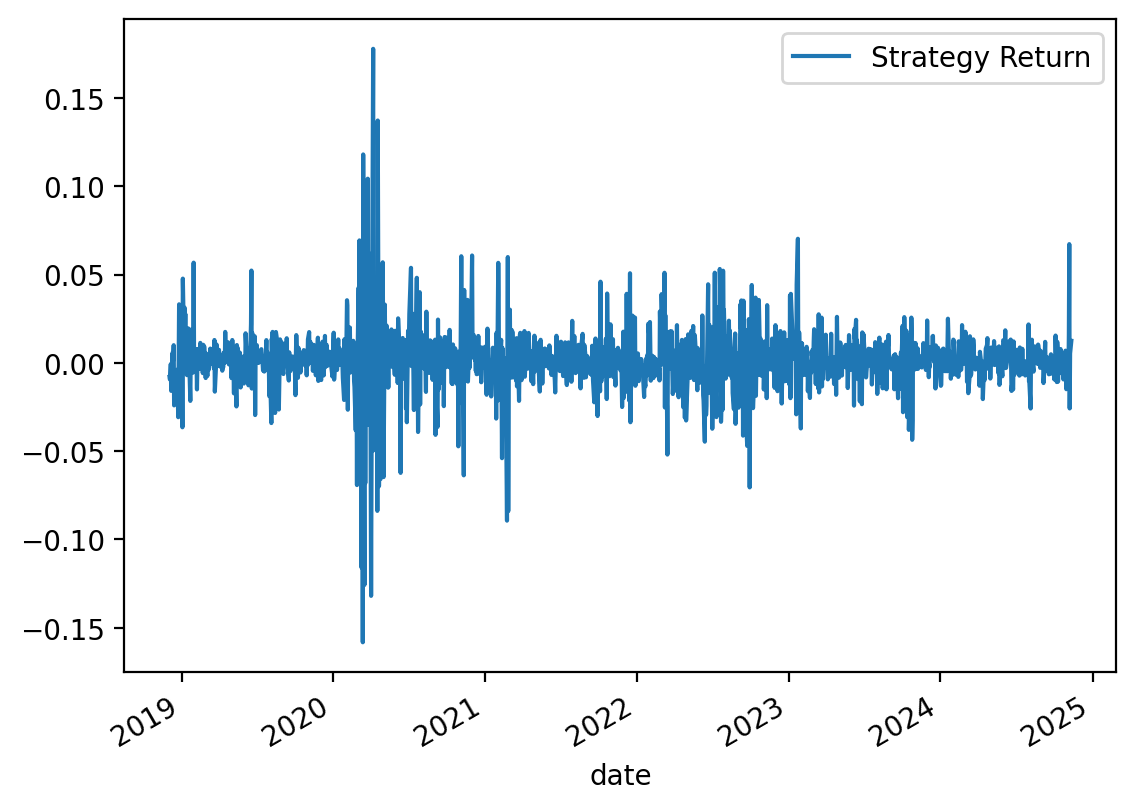

In [28]:
portfolio_df.plot()

In [29]:
spy = yf.download(tickers='SPY', start='2015-01-01', end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

[*********************100%%**********************]  1 of 1 completed


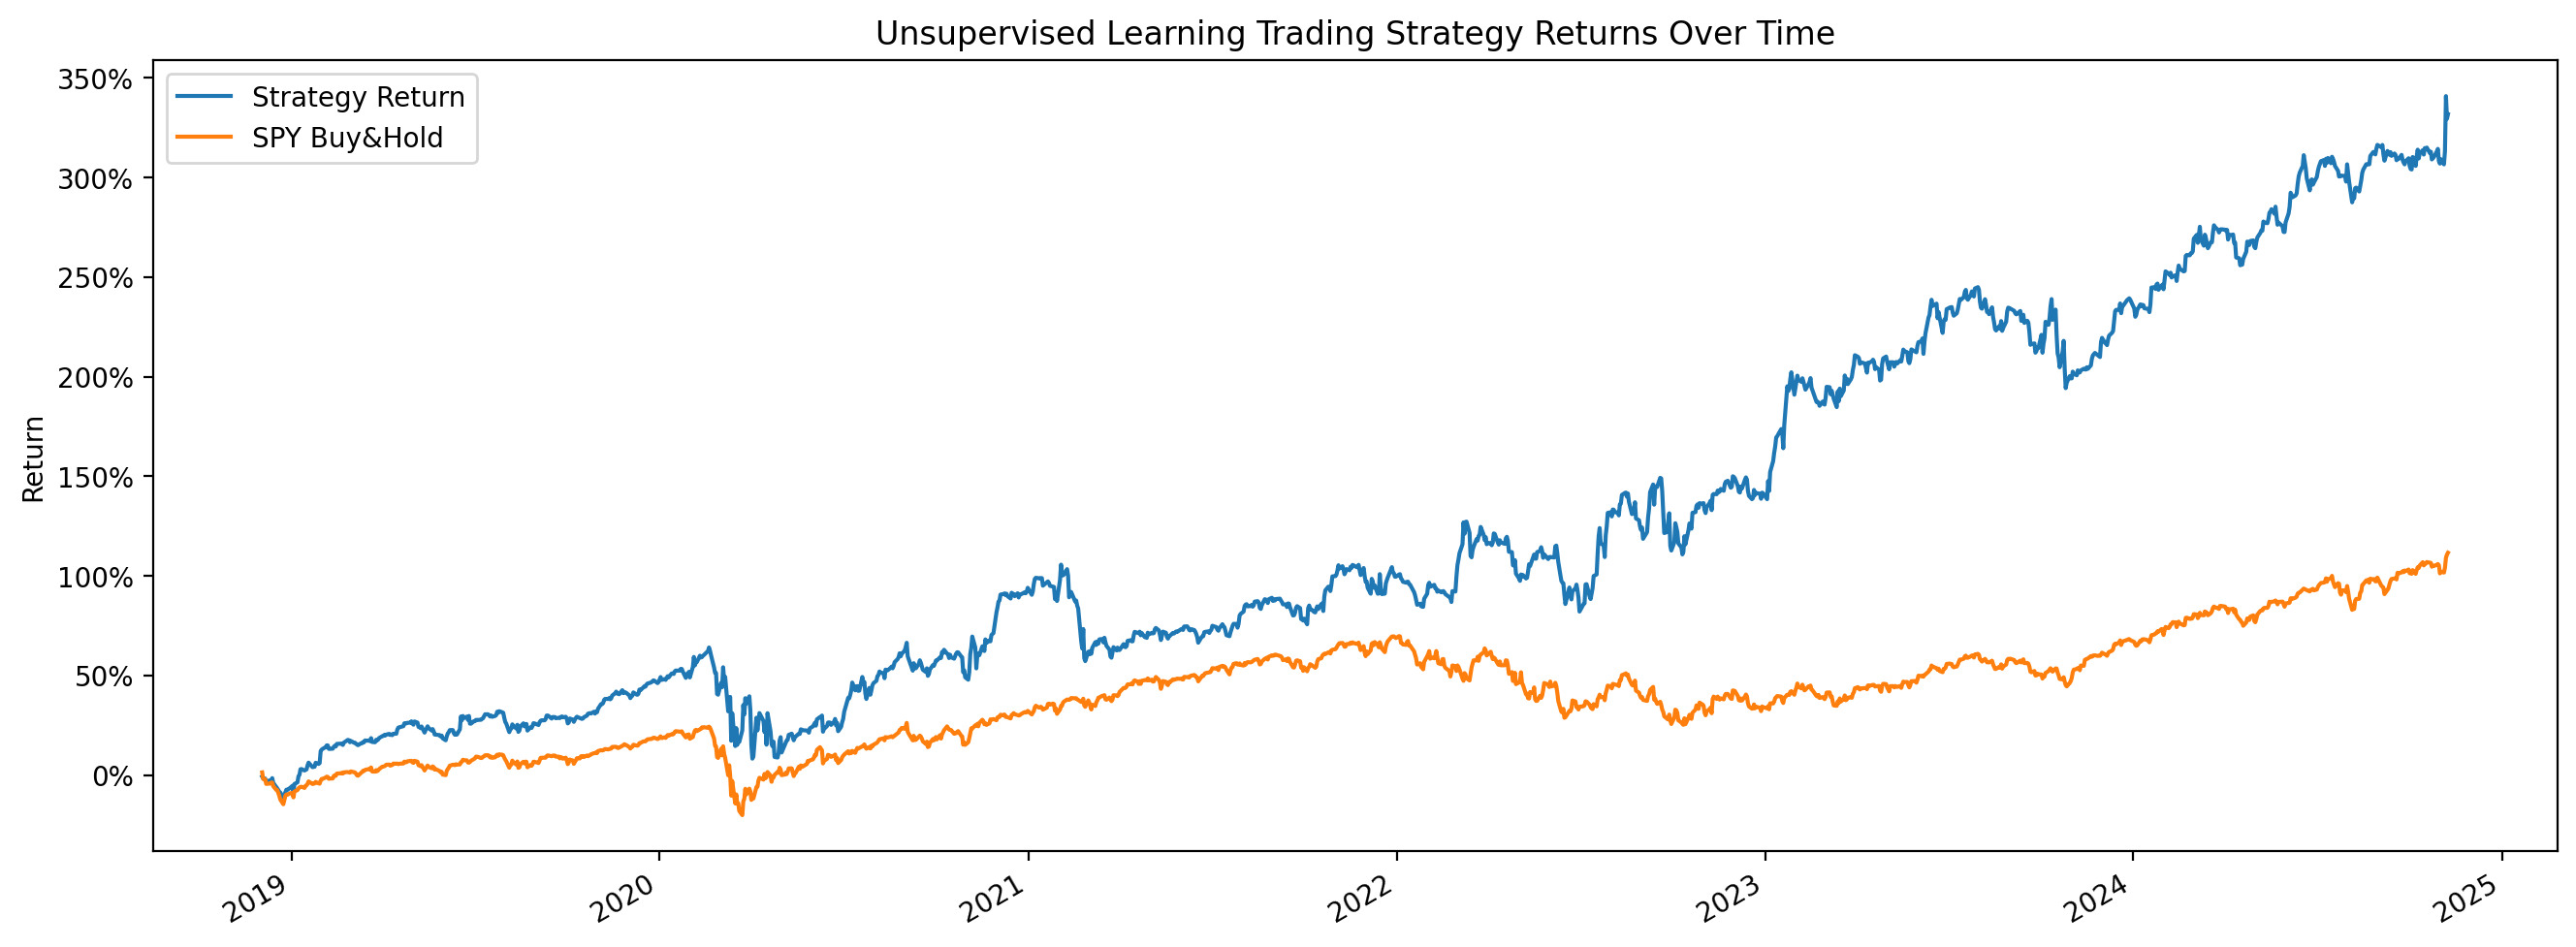

In [30]:
import matplotlib.ticker as mtick

portfolio_cumulative_ret = np.exp(np.log1p(portfolio_df).cumsum()) - 1 
portfolio_cumulative_ret.plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

In [31]:
(np.exp(np.log1p(portfolio_df).cumsum()) - 1)['Strategy Return'][-1]

3.317553535395537

In [32]:
apy = (np.exp(np.log1p(portfolio_df).cumsum()) - 1)['Strategy Return'][-1]/((portfolio_df.index[-1] - portfolio_df.index[0]) / pd.Timedelta(days=365))
apy

0.5587942041621462

In [33]:
key_date = list(weights_by_month.keys())

In [34]:
print(key_date[-2])
weights_by_month[key_date[-2]]

2024-11-01


,BKNG,CMCSA,WFC
0,0.46764,0.10001,0.43235


In [35]:
print(key_date[-1])
weights_by_month[key_date[-1]]

2024-12-01


,AMZN,BAC,BKNG,CRM,CSCO,GOOG,GOOGL,GS,INTC,NFLX,NVDA,ORCL,TSLA,V,WFC
0,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667


In [36]:
def compound_interest_cal_w_m(p:float, r:float, c:float, n:float, monthly_addition:float) -> float:
    """Calculate compound interest with monthly addition

    Args:
        p (flot): The principal amount.
        r (flot): The annual interest rate.
        c (flot): The number of compounding periods per year.
        n (flot): The number of years.
        monthly_addition (flot): The monthly contribution.

    Returns:
        flot: The future value of the investment.
    """
    term1 = p * (1 + r/c) ** (c*n)
    term2 = (monthly_addition * ((1 + r/c) ** (c*n) - 1)) / (r/c)
    return term1 + term2

In [37]:
apy = (np.exp(np.log1p(portfolio_df).cumsum()) - 1)['Strategy Return'][-1]/((portfolio_df.index[-1] - portfolio_df.index[0]) / pd.Timedelta(days=365))
compound_interest_cal_w_m(3000, apy, 12, 8, 250)

655722.1331812572

<Axes: >

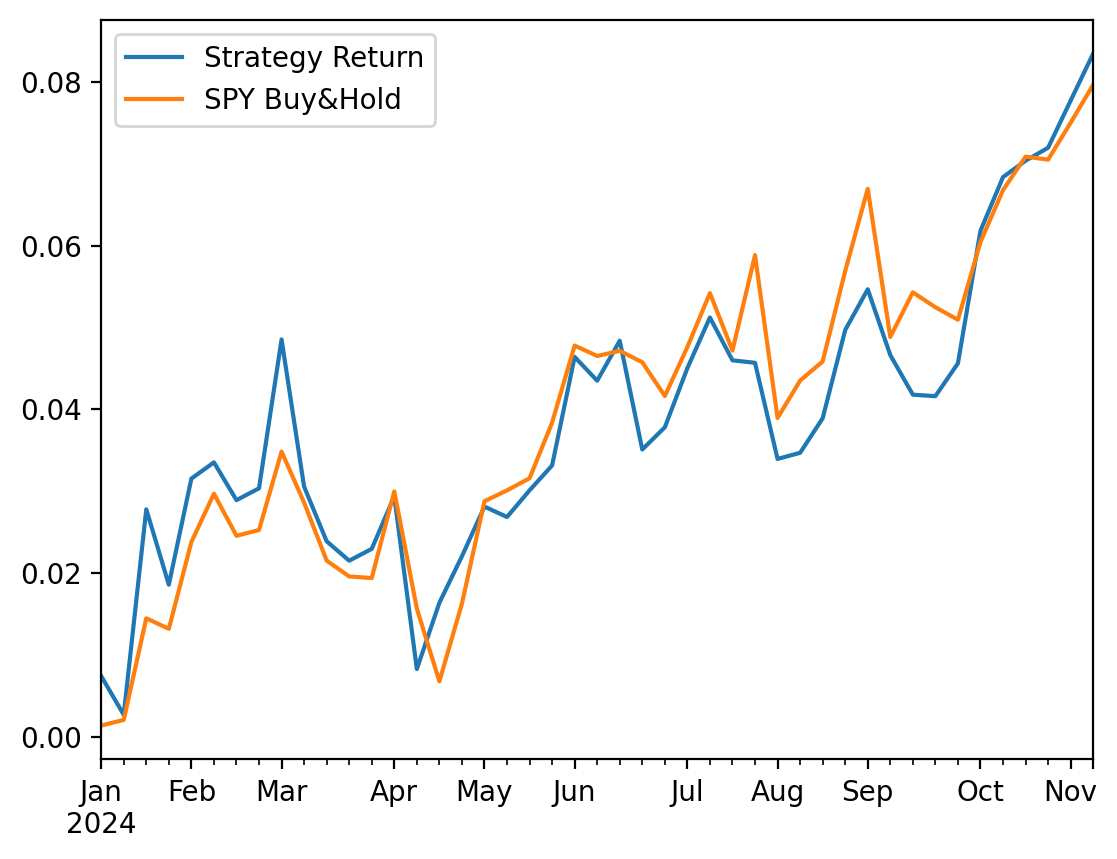

In [38]:
(np.exp(np.log1p(portfolio_df['2024-01-01':].asfreq('B').resample('W').last()).cumsum()) - 1).plot()